# Baseline Models

This notebook contains the models that we will use as a baseline to evaluate other models.

Here we are using two models:
1. Logistic Regression
2. XGBoost

Importing relevant libraries

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

Data Loading and Merging

Loads historical stock data for multiple assets from CSV files, organizing them into training and testing datasets.  

- Stocks: **BBAS3.SA, CSNA3.SA, PETR4.SA, VALE3.SA**  
  


In [2]:
# Define data directory and stock symbols
data_dir = '/home/mark/Repo/DesafioCartesius/cartesius-tech-challenge/data/FIAP_PI'
stocks = ['BBAS3.SA', 'CSNA3.SA', 'PETR4.SA', 'VALE3.SA']

# Load and concatenate training and testing datasets
train_dfs, test_dfs = [], []
for stock in stocks:
    stock_dir = os.path.join(data_dir, stock)
    train_dfs.append(pd.read_csv(f"{stock_dir}/treino.csv", index_col=0))
    test_dfs.append(pd.read_csv(f"{stock_dir}/teste.csv", index_col=0))

# train_df = pd.concat(train_dfs, ignore_index=False)
# test_df = pd.concat(test_dfs, ignore_index=False)


Adjusting labels to fit models parameters.

In [3]:
# Replace -1 with 0 in the label column of train_df and test_df
# train_df.iloc[:, 3] = train_df.iloc[:, 3].replace(-1, 0)
# test_df.iloc[:, 3] = test_df.iloc[:, 3].replace(-1, 0)

# Replace -1 with 0 in the label column of the train_dfs
for df in train_dfs:
    df.iloc[:, 3] = df.iloc[:, 3].replace(-1, 0)

# Apply the same transformation to each individual test DataFrame in test_dfs
for df in test_dfs:
    df.iloc[:, 3] = df.iloc[:, 3].replace(-1, 0)


Defining models hyperparameters.

In [4]:
# logistic regression
max_iter = 1000

# xgboost
n_estimators = 200
max_depth = 2

Define model training and evaluation methods.

In [11]:
def backtest_strategy_np(prices, predictions, initial_cash=10000, price_index=0):
    cash = initial_cash
    position = 0
    portfolio_values = []
    
    for i in range(len(prices)):
        price = prices[i]
        signal = int(predictions[i])
        
        if signal == 1 and position == 0:
            shares_to_buy = int(cash // price)
            if shares_to_buy > 0:
                position = shares_to_buy
                cash -= position * price

        elif signal == 0 and position > 0:
            cash += position * price
            position = 0
        
        portfolio_value = cash + position * price
        portfolio_values.append(portfolio_value)
    
    # Final liquidation if still holding a position
    if position > 0:
        if prices.ndim > 1:
            final_price = float(prices[-1, price_index])
        else:
            final_price = float(prices[-1])
        cash += position * final_price
        position = 0
    
    final_value = cash
    return portfolio_values, final_value

In [12]:
# Function to fit a classifier and evaluate its performance
def fit_classifier(X_train, X_test, y_train, y_test, model, test, prices):
    # Train the model using the training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print model evaluation results
    print(f"Model: {model.__class__}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1: {f1:.2f}")
    print(f"Confusion matrix:")
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=plt.cm.Blues)  # Use a blue colormap for clarity
    plt.show()
    print()

    if test:
        # prices = test_df.iloc[:,2].to_numpy()

        # Run the backtest simulation
        portfolio_values, final_value = backtest_strategy_np(prices, y_pred, initial_cash=10000, price_index=0)
        print(f"Final portfolio value for {stock}: R${final_value:.2f}")

        # Create a dual Y-axis plot
        fig, ax1 = plt.subplots(figsize=(10, 5))
        ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis

        # Plot stock prices on the left y-axis
        ax1.plot(prices, label='Stock Price', color='blue', linewidth=2)
        ax1.set_xlabel('Time Step')
        ax1.set_ylabel('Stock Price', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        # Plot portfolio values on the right y-axis
        ax2.plot(portfolio_values, label='Portfolio Value', color='orange', linestyle='--', linewidth=2)
        ax2.set_ylabel('Portfolio Value', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')

        # Title and legend
        plt.title(f'Stock Price and Portfolio Value Over Time for {stock}')
        fig.tight_layout()
        fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
        plt.show()
        print()

# Main function to train and evaluate models
def main(X_train, X_test, y_train, y_test, test, prices):
    # Initialize Logistic Regression model with a specified max_iter
    logistic_regression_model = LogisticRegression(max_iter=max_iter)  # Increase max_iter if needed
    fit_classifier(X_train, X_test, y_train, y_test, logistic_regression_model, test, prices)
    
    # Initialize XGBoost classifier with specified parameters
    xgboost_model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, objective='binary:logistic')
    fit_classifier(X_train, X_test, y_train, y_test, xgboost_model, test, prices)


Validation results

Train results for stock: BBAS3.SA
Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Accuracy: 0.86
Precision: 0.89
Recall: 0.81
F1: 0.85
Confusion matrix:


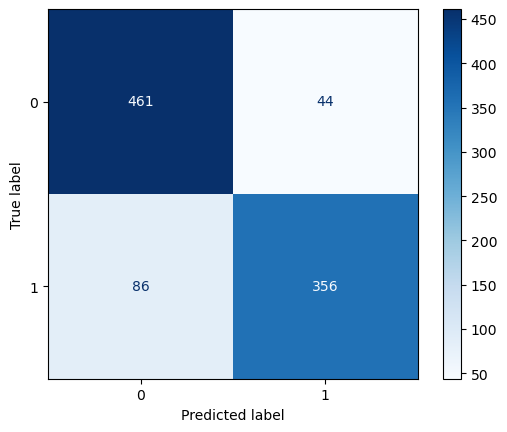


Model: <class 'xgboost.sklearn.XGBClassifier'>
Accuracy: 0.85
Precision: 0.83
Recall: 0.86
F1: 0.84
Confusion matrix:


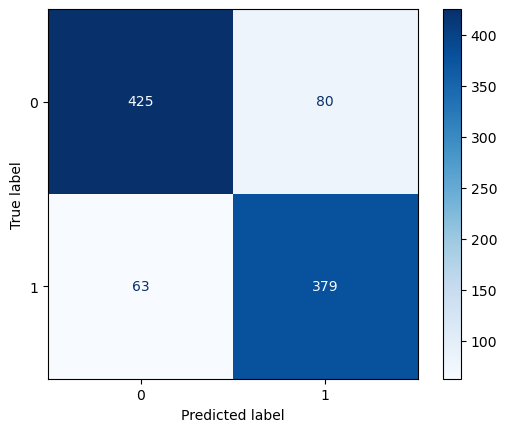



Validation results

Train results for stock: CSNA3.SA
Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Accuracy: 0.86
Precision: 0.87
Recall: 0.83
F1: 0.85
Confusion matrix:


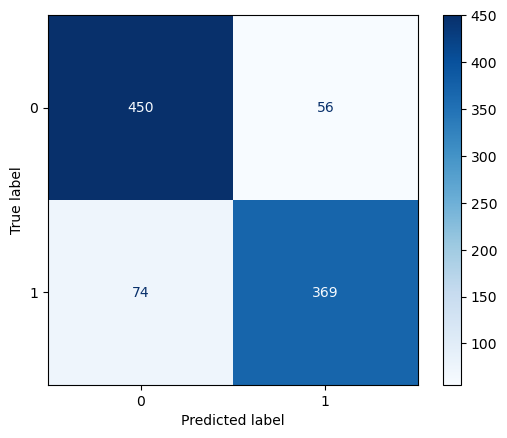


Model: <class 'xgboost.sklearn.XGBClassifier'>
Accuracy: 0.89
Precision: 0.88
Recall: 0.88
F1: 0.88
Confusion matrix:


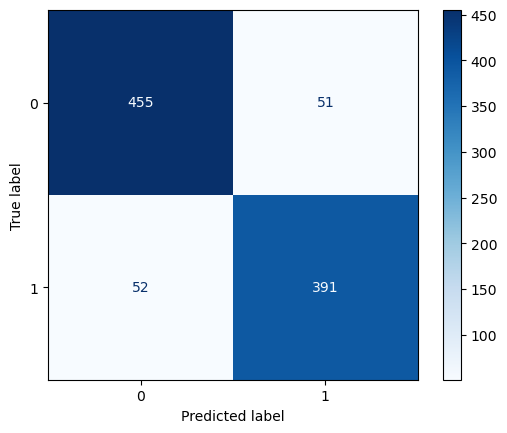



Validation results

Train results for stock: PETR4.SA
Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Accuracy: 0.88
Precision: 0.88
Recall: 0.84
F1: 0.86
Confusion matrix:


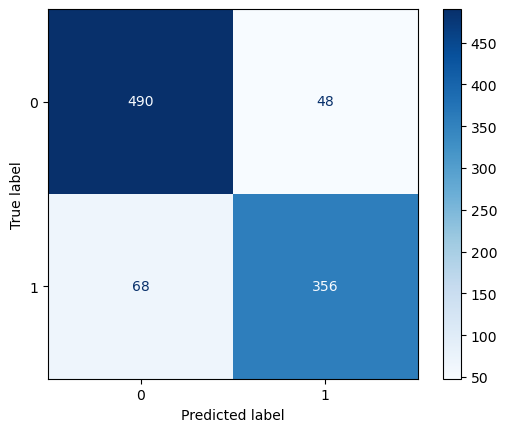


Model: <class 'xgboost.sklearn.XGBClassifier'>
Accuracy: 0.87
Precision: 0.86
Recall: 0.85
F1: 0.85
Confusion matrix:


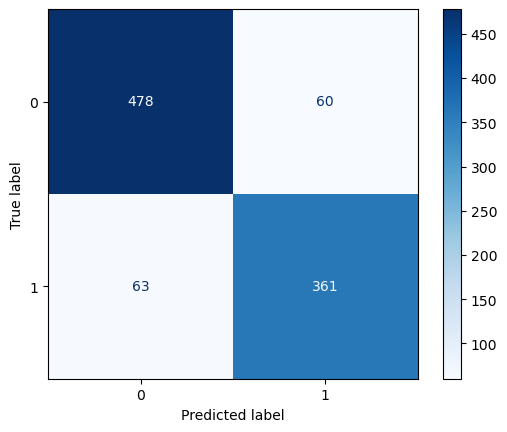



Validation results

Train results for stock: VALE3.SA
Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Accuracy: 0.87
Precision: 0.89
Recall: 0.81
F1: 0.85
Confusion matrix:


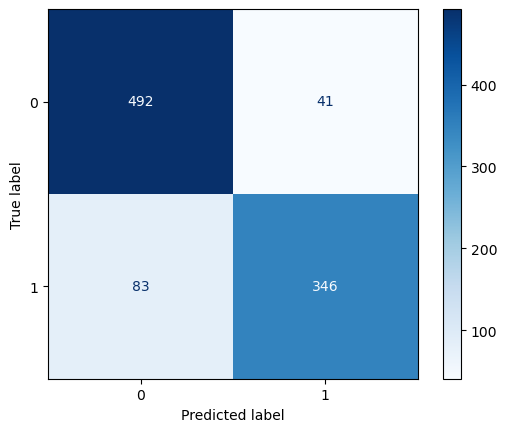


Model: <class 'xgboost.sklearn.XGBClassifier'>
Accuracy: 0.85
Precision: 0.84
Recall: 0.83
F1: 0.83
Confusion matrix:


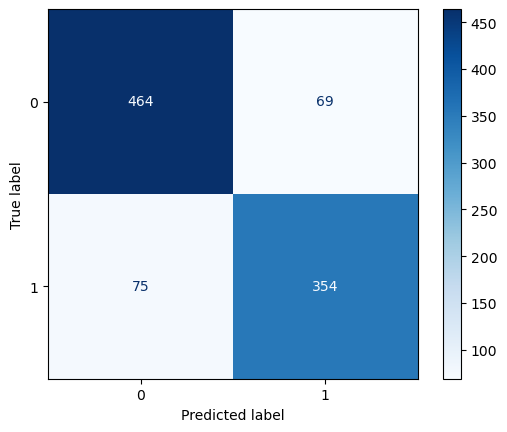

In [9]:
# Train models on train data for each stock
for stock_name, stock_train_df in zip(stocks, train_dfs):
    X = stock_train_df.iloc[:, 4:].values
    y = stock_train_df.iloc[:, 3].values

    # Split the data into training (80%) and validation (20%) sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Display validation results for the current stock
    print("Validation results\n")
    print(f"Train results for stock: {stock_name}")
    main(X_train, X_val, y_train, y_val, test=False, prices=None)
    print()

Test on each stock dataset.

Test results for stock: BBAS3.SA
Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Accuracy: 0.89
Precision: 0.84
Recall: 0.90
F1: 0.87
Confusion matrix:


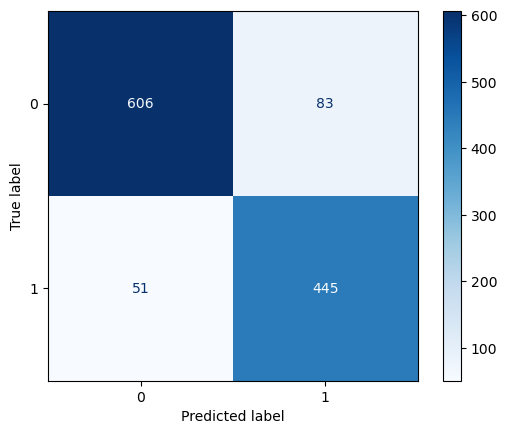


Final portfolio value for VALE3.SA: R$61876.30


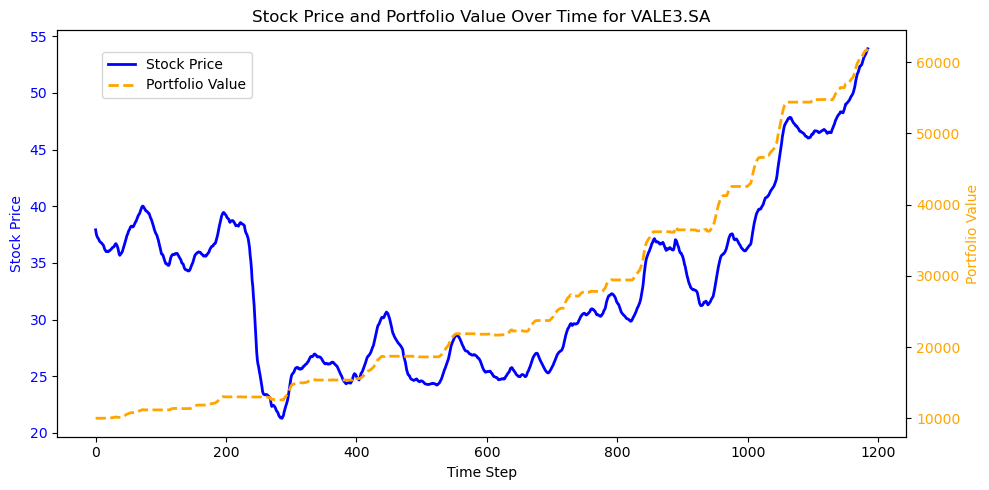


Model: <class 'xgboost.sklearn.XGBClassifier'>
Accuracy: 0.62
Precision: 0.53
Recall: 0.91
F1: 0.67
Confusion matrix:


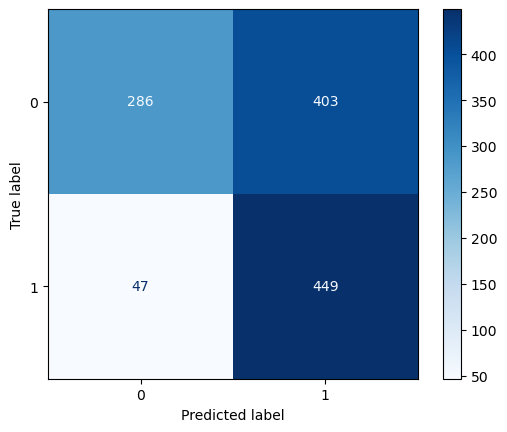


Final portfolio value for VALE3.SA: R$37722.00


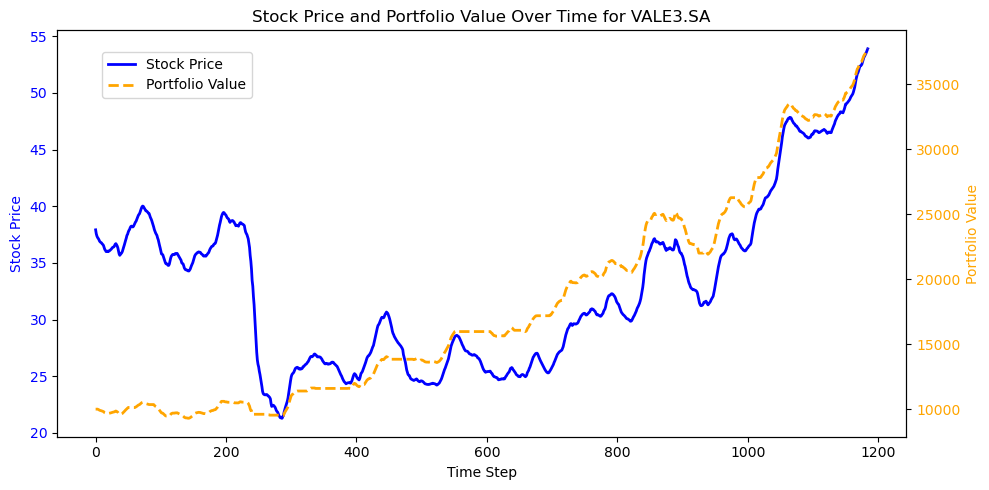



Test results for stock: CSNA3.SA
Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Accuracy: 0.88
Precision: 0.81
Recall: 0.94
F1: 0.87
Confusion matrix:


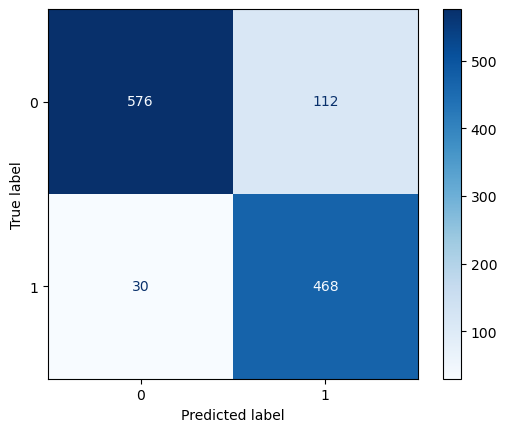


Final portfolio value for VALE3.SA: R$304121.20


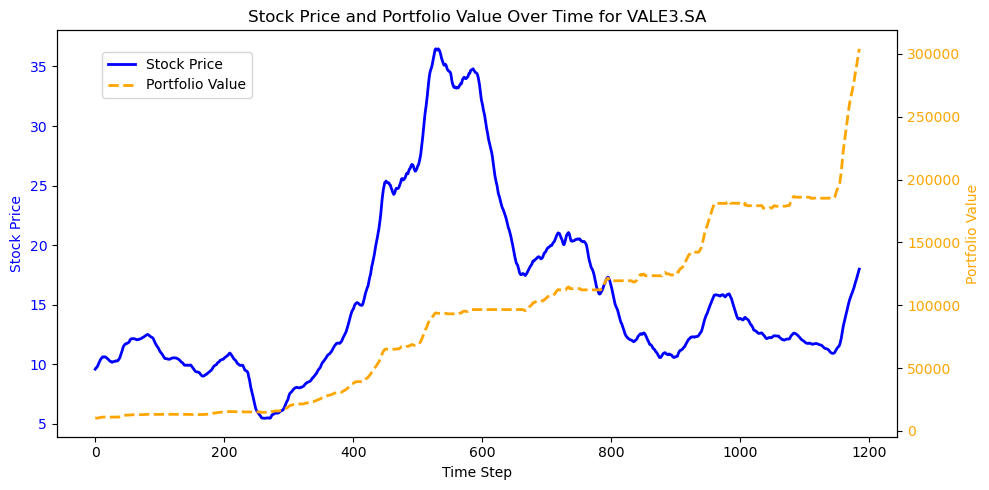


Model: <class 'xgboost.sklearn.XGBClassifier'>
Accuracy: 0.70
Precision: 0.60
Recall: 0.89
F1: 0.72
Confusion matrix:


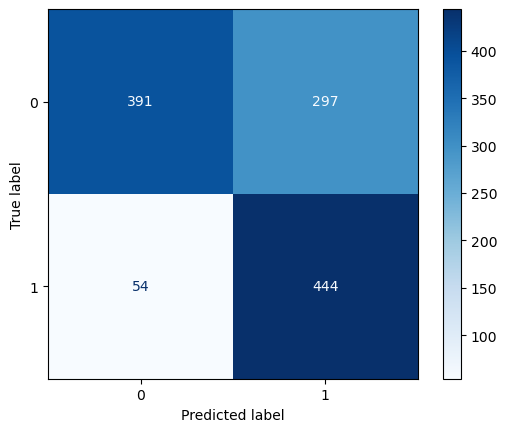


Final portfolio value for VALE3.SA: R$106843.43


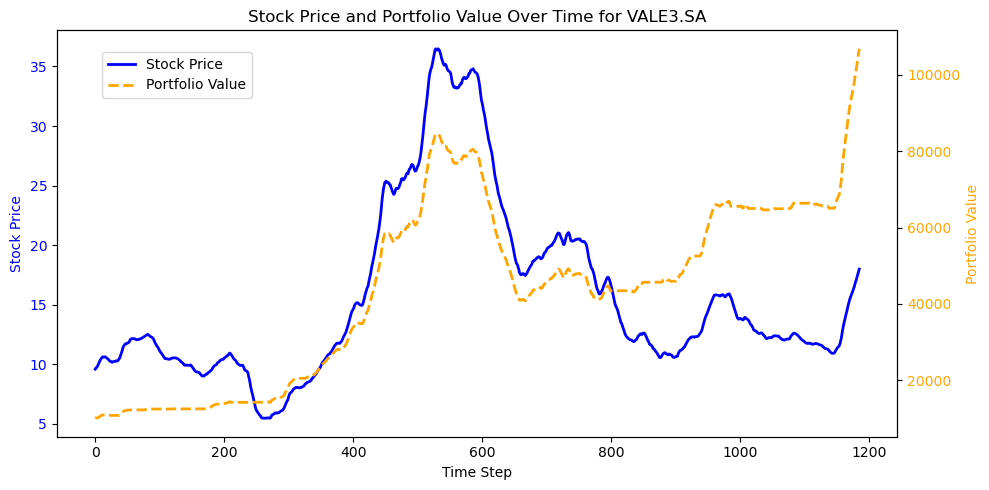



Test results for stock: PETR4.SA
Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Accuracy: 0.86
Precision: 0.86
Recall: 0.88
F1: 0.87
Confusion matrix:


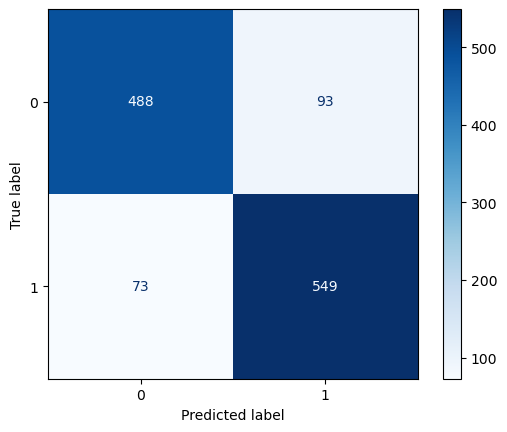


Final portfolio value for VALE3.SA: R$149479.20


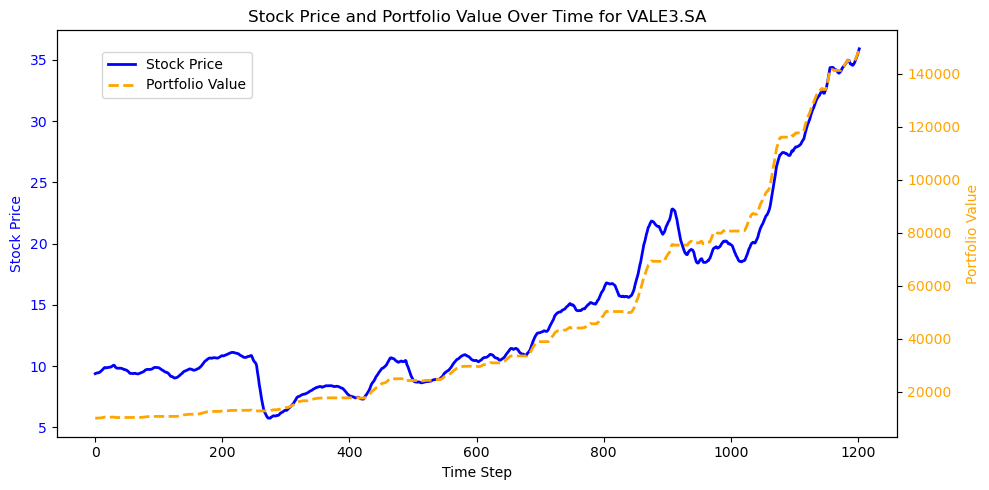


Model: <class 'xgboost.sklearn.XGBClassifier'>
Accuracy: 0.67
Precision: 0.83
Recall: 0.46
F1: 0.59
Confusion matrix:


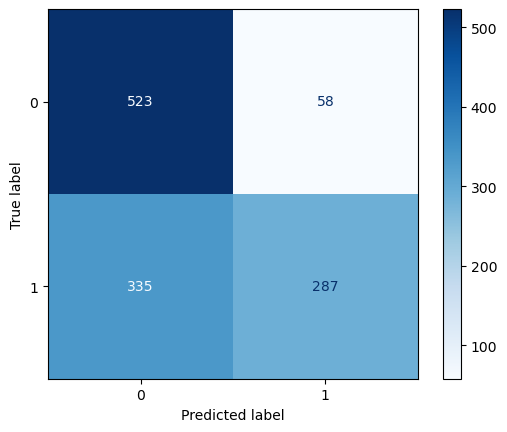


Final portfolio value for VALE3.SA: R$39653.37


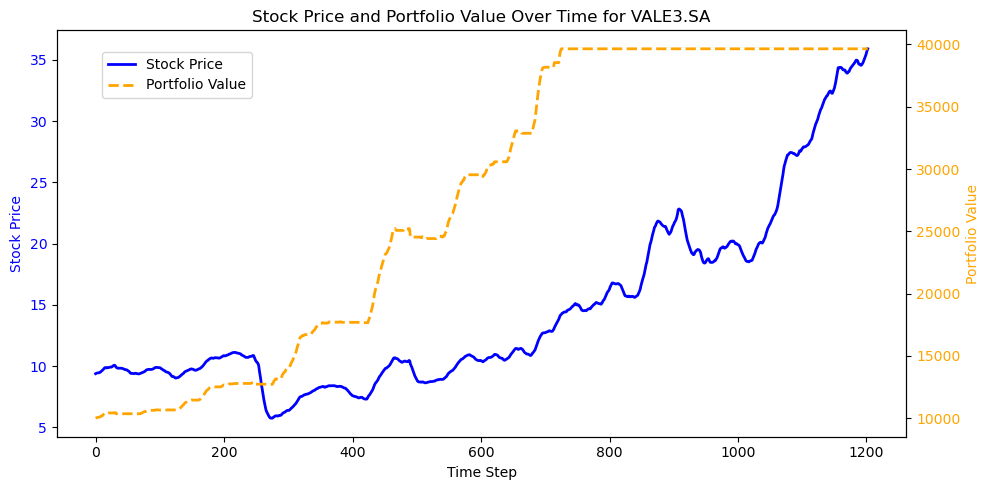



Test results for stock: VALE3.SA
Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Accuracy: 0.87
Precision: 0.89
Recall: 0.84
F1: 0.87
Confusion matrix:


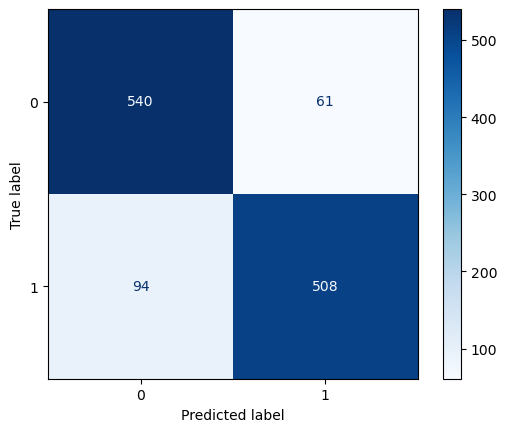


Final portfolio value for VALE3.SA: R$88830.09


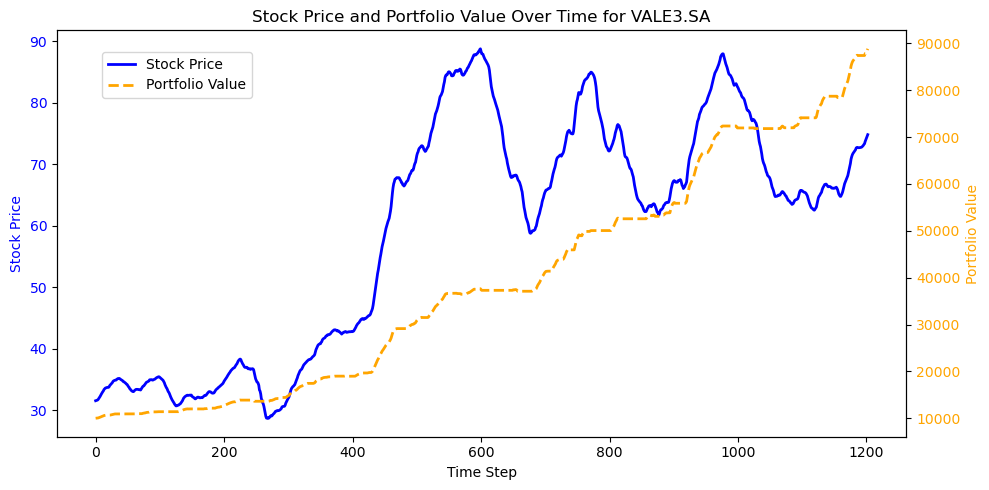


Model: <class 'xgboost.sklearn.XGBClassifier'>
Accuracy: 0.59
Precision: 0.84
Recall: 0.22
F1: 0.35
Confusion matrix:


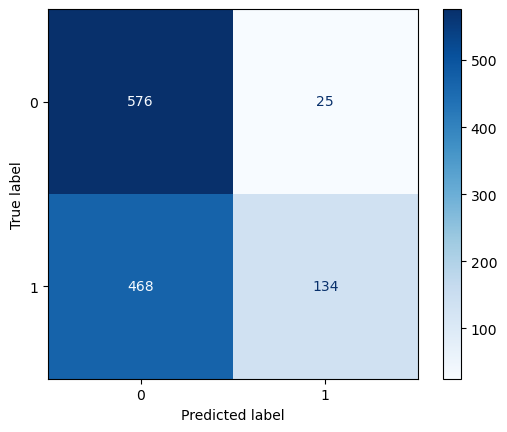


Final portfolio value for VALE3.SA: R$16404.33


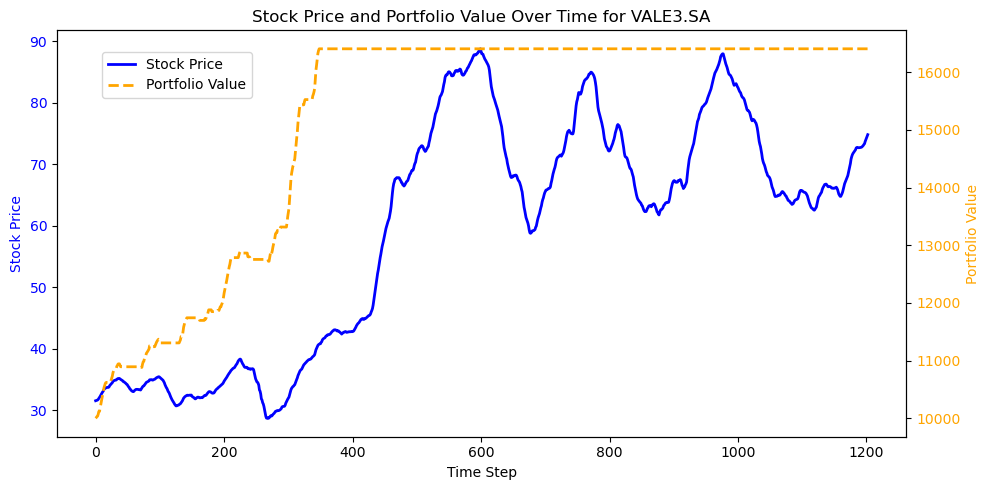

In [13]:
# Evaluate models on test data for each stock
for stock_name, stock_train_df, stock_test_df in zip(stocks, train_dfs, test_dfs):
    X = stock_train_df.iloc[:, 4:].values
    y = stock_train_df.iloc[:, 3].values
    X_test = stock_test_df.iloc[:, 4:].values
    y_test = stock_test_df.iloc[:, 3].values

    # Print evaluation results for the current stock
    print(f"Test results for stock: {stock_name}")
    main(X, X_test, y, y_test, test=True, prices = stock_test_df.iloc[:,2].to_numpy())
    print()
